# Lending Club Loan Status Prediction - Neural Network Classification


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
# Configure matplotlib and seaborn
plt.style.use('default')
sns.set_palette("husl")

In [6]:
print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

All libraries imported successfully!
TensorFlow version: 2.18.0



# 1. DATA LOADING AND INITIAL EXPLORATION


In [9]:
# Load the dataset
try:
    df = pd.read_csv('lending_club_loan_two.csv')
    print("Dataset loaded successfully!")
    print(f"Dataset shape: {df.shape}")
except FileNotFoundError:
    print("Please upload your 'lending_club_two.csv' file to Colab first")
    print("Use the file upload button in the sidebar or:")
    print("from google.colab import files")
    print("files.upload()")

Dataset loaded successfully!
Dataset shape: (396030, 27)


In [10]:
# Display basic information about the dataset
print("DATASET OVERVIEW")
print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

DATASET OVERVIEW
Dataset shape: (396030, 27)
Memory usage: 421.42 MB


In [11]:
# Display first few rows
print("\nFirst 5 rows:")
print(df.head())


First 5 rows:
   loan_amnt        term  int_rate  installment grade sub_grade  \
0    10000.0   36 months     11.44       329.48     B        B4   
1     8000.0   36 months     11.99       265.68     B        B5   
2    15600.0   36 months     10.49       506.97     B        B3   
3     7200.0   36 months      6.49       220.65     A        A2   
4    24375.0   60 months     17.27       609.33     C        C5   

                 emp_title emp_length home_ownership  annual_inc  ...  \
0                Marketing  10+ years           RENT    117000.0  ...   
1          Credit analyst     4 years       MORTGAGE     65000.0  ...   
2             Statistician   < 1 year           RENT     43057.0  ...   
3          Client Advocate    6 years           RENT     54000.0  ...   
4  Destiny Management Inc.    9 years       MORTGAGE     55000.0  ...   

  open_acc pub_rec revol_bal revol_util total_acc  initial_list_status  \
0     16.0     0.0   36369.0       41.8      25.0                    

In [12]:
# Display data types and missing values
print("\nData Types and Missing Values:")
info_df = pd.DataFrame({
    'Column': df.columns,
    'Data Type': df.dtypes,
    'Missing Values': df.isnull().sum(),
    'Missing %': (df.isnull().sum() / len(df) * 100).round(2)
})
print(info_df)


Data Types and Missing Values:
                                    Column Data Type  Missing Values  \
loan_amnt                        loan_amnt   float64               0   
term                                  term    object               0   
int_rate                          int_rate   float64               0   
installment                    installment   float64               0   
grade                                grade    object               0   
sub_grade                        sub_grade    object               0   
emp_title                        emp_title    object           22927   
emp_length                      emp_length    object           18301   
home_ownership              home_ownership    object               0   
annual_inc                      annual_inc   float64               0   
verification_status    verification_status    object               0   
issue_d                            issue_d    object               0   
loan_status                    l

In [13]:
# Basic statistics
print("\nBasic Statistics for Numerical Columns:")
print(df.describe())


Basic Statistics for Numerical Columns:
           loan_amnt       int_rate    installment    annual_inc  \
count  396030.000000  396030.000000  396030.000000  3.960300e+05   
mean    14113.888089      13.639400     431.849698  7.420318e+04   
std      8357.441341       4.472157     250.727790  6.163762e+04   
min       500.000000       5.320000      16.080000  0.000000e+00   
25%      8000.000000      10.490000     250.330000  4.500000e+04   
50%     12000.000000      13.330000     375.430000  6.400000e+04   
75%     20000.000000      16.490000     567.300000  9.000000e+04   
max     40000.000000      30.990000    1533.810000  8.706582e+06   

                 dti       open_acc        pub_rec     revol_bal  \
count  396030.000000  396030.000000  396030.000000  3.960300e+05   
mean       17.379514      11.311153       0.178191  1.584454e+04   
std        18.019092       5.137649       0.530671  2.059184e+04   
min         0.000000       0.000000       0.000000  0.000000e+00   
25%   

# 2. EXPLORATORY DATA ANALYSIS (EDA)


Text(0.5, 0.98, 'Lending Club Dataset - Exploratory Data Analysis')

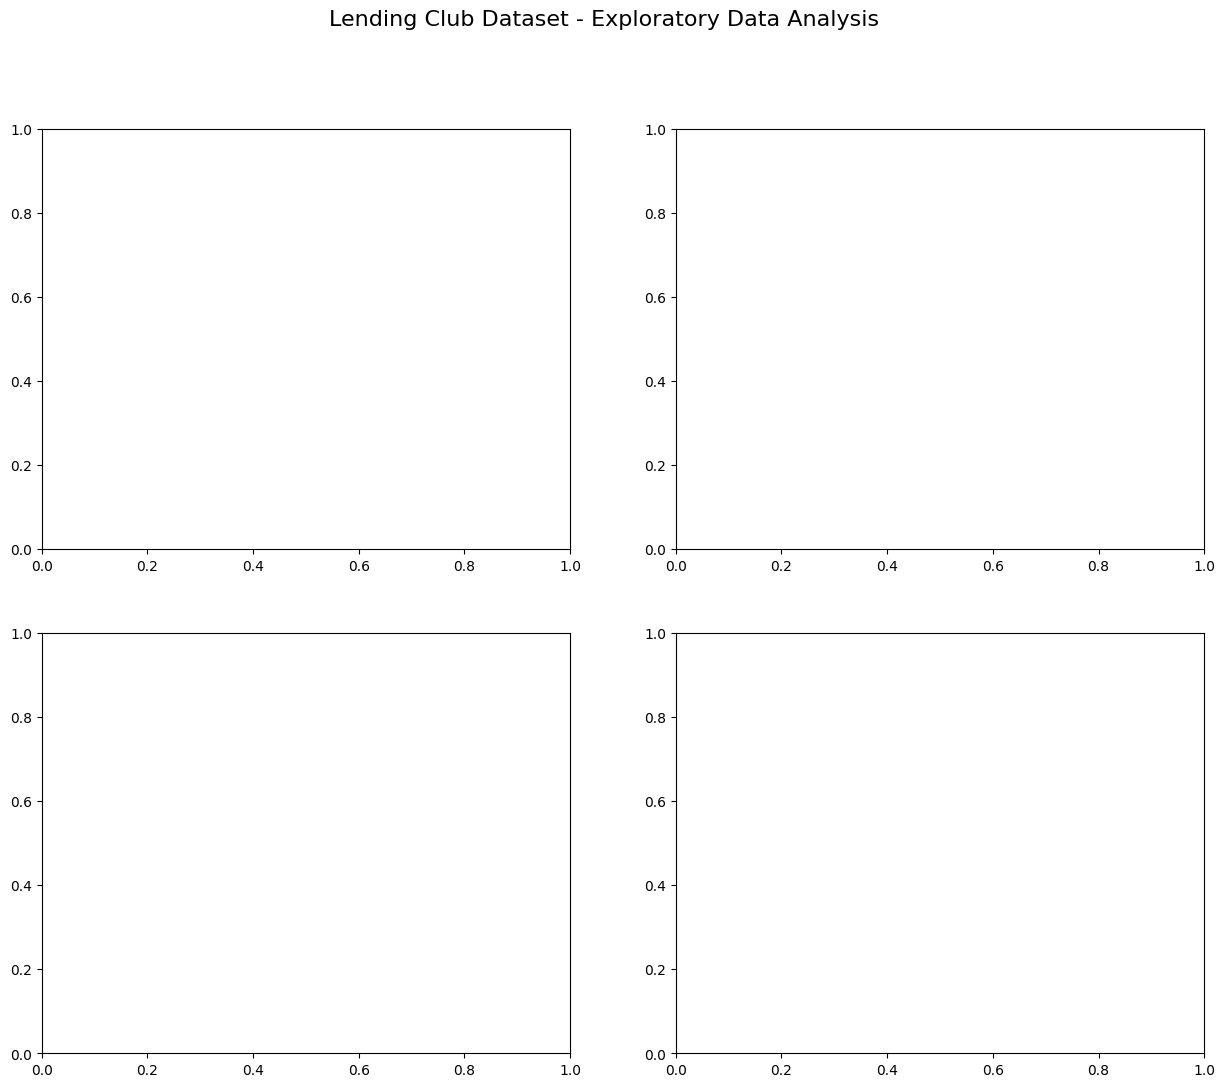

In [14]:
# Create figure for EDA plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Lending Club Dataset - Exploratory Data Analysis', fontsize=16)

In [15]:
# 1. Target Variable Distribution
if 'loan_status' in df.columns:
    loan_status_counts = df['loan_status'].value_counts()
    axes[0, 0].pie(loan_status_counts.values, labels=loan_status_counts.index, autopct='%1.1f%%')
    axes[0, 0].set_title('Distribution of Loan Status')
    print(f"\nLoan Status Distribution:")
    print(loan_status_counts)
    print(f"Class balance ratio: {loan_status_counts.min()/loan_status_counts.max():.3f}")


Loan Status Distribution:
loan_status
Fully Paid     318357
Charged Off     77673
Name: count, dtype: int64
Class balance ratio: 0.244


In [16]:
# 2. Loan Amount Distribution
if 'loan_amnt' in df.columns:
    axes[0, 1].hist(df['loan_amnt'].dropna(), bins=50, alpha=0.7, color='skyblue')
    axes[0, 1].set_title('Distribution of Loan Amount')
    axes[0, 1].set_xlabel('Loan Amount ($)')
    axes[0, 1].set_ylabel('Frequency')

In [17]:
# 3. Interest Rate Distribution
if 'int_rate' in df.columns:
    axes[1, 0].hist(df['int_rate'].dropna(), bins=30, alpha=0.7, color='lightcoral')
    axes[1, 0].set_title('Distribution of Interest Rate')
    axes[1, 0].set_xlabel('Interest Rate (%)')
    axes[1, 0].set_ylabel('Frequency')

In [18]:
# 4. Grade Distribution
if 'grade' in df.columns:
    grade_counts = df['grade'].value_counts().sort_index()
    axes[1, 1].bar(grade_counts.index, grade_counts.values, color='lightgreen')
    axes[1, 1].set_title('Distribution of Loan Grades')
    axes[1, 1].set_xlabel('Grade')
    axes[1, 1].set_ylabel('Count')

In [20]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

## Correlation Analysis for Numerical Features


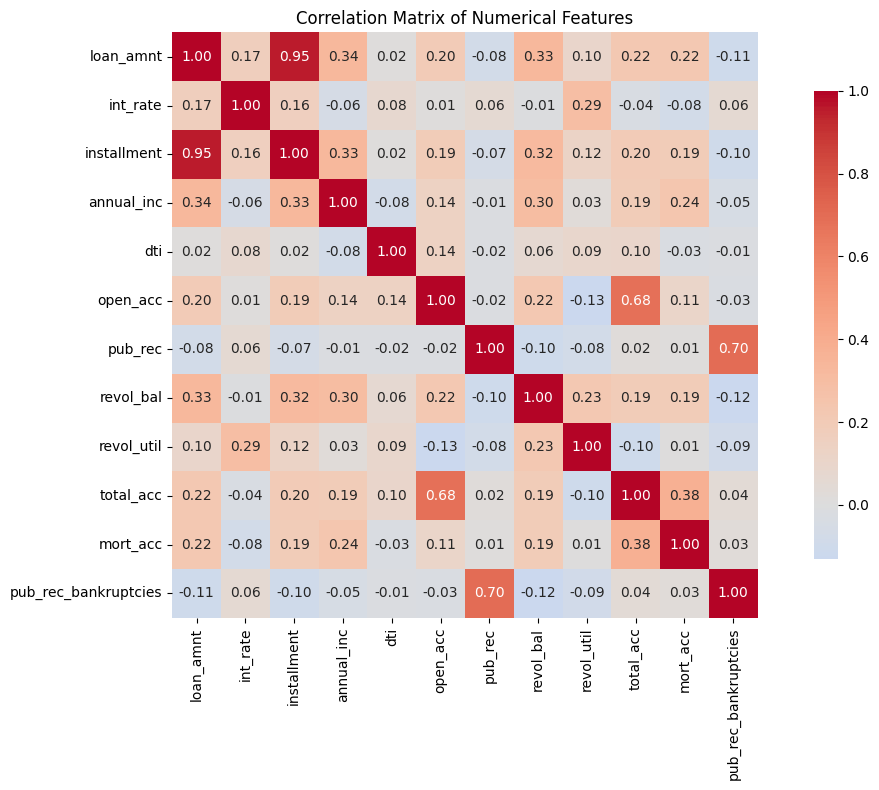

In [21]:
# Select numerical columns for correlation analysis
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(numerical_cols) > 1:
    plt.figure(figsize=(12, 8))
    correlation_matrix = df[numerical_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.2f', cbar_kws={"shrink": .8})
    plt.title('Correlation Matrix of Numerical Features')
    plt.tight_layout()
    plt.show()


In [24]:
# Find highly correlated features
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
  for j in range(i+1, len(correlation_matrix.columns)):
      if abs(correlation_matrix.iloc[i, j]) > 0.7:
          high_corr_pairs.append((
              correlation_matrix.columns[i],
              correlation_matrix.columns[j],
              correlation_matrix.iloc[i, j]
          ))

if high_corr_pairs:
  print("Highly correlated feature pairs (|r| > 0.7):")
  for pair in high_corr_pairs:
      print(f"  {pair[0]} - {pair[1]}: {pair[2]:.3f}")
else:
  print("No highly correlated feature pairs found (|r| > 0.7)")

Highly correlated feature pairs (|r| > 0.7):
  loan_amnt - installment: 0.954


Text(0.5, 0.98, 'Additional EDA - Feature Relationships')

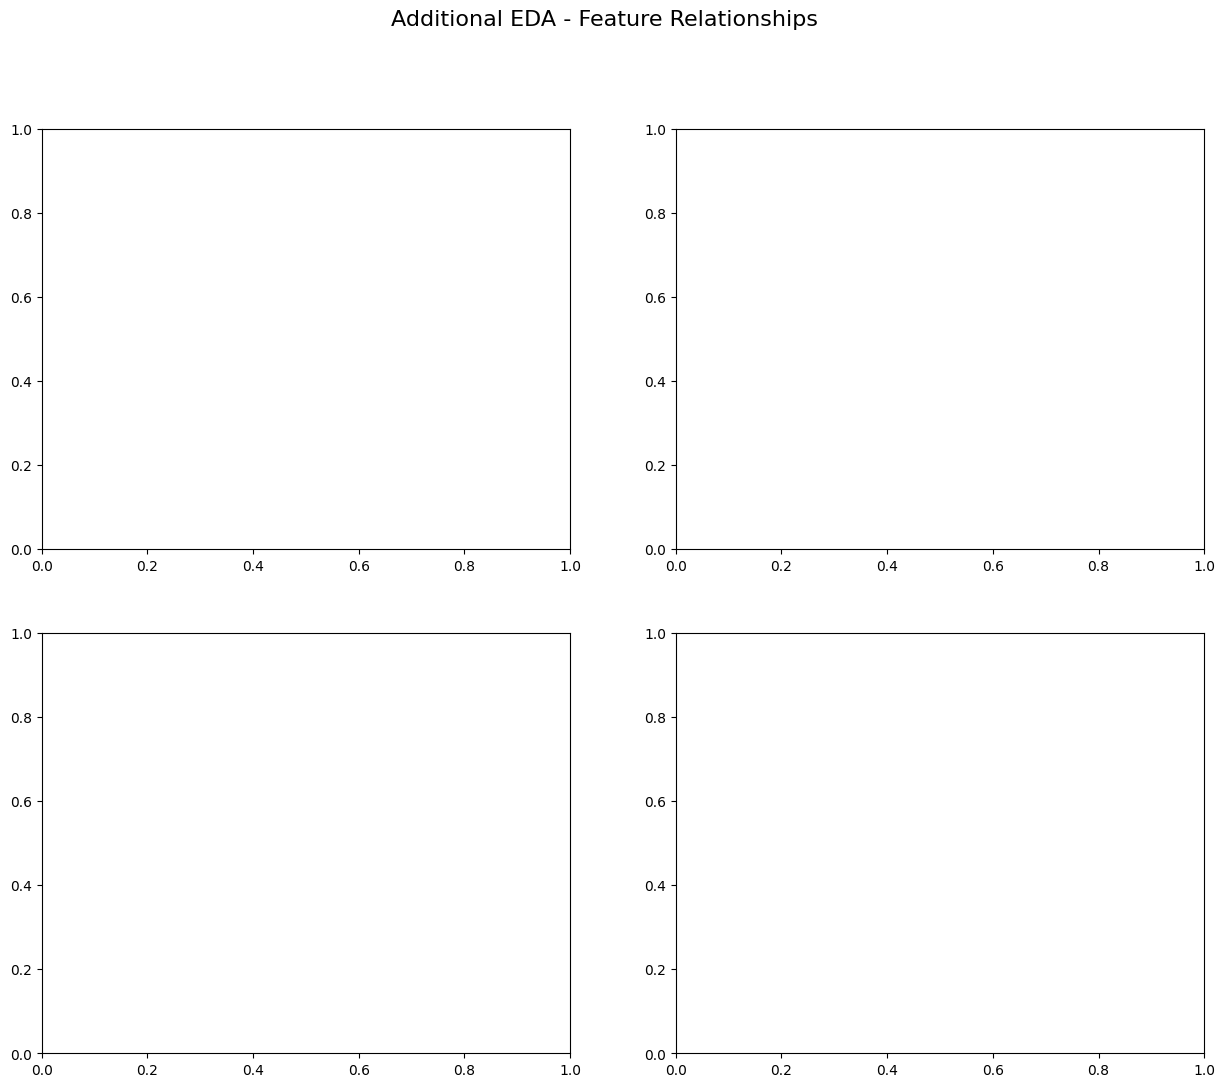

In [25]:
# Additional EDA plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Additional EDA - Feature Relationships', fontsize=16)

In [28]:
# Loan Amount vs Interest Rate
if 'loan_amnt' in df.columns and 'int_rate' in df.columns:
    axes[0, 0].scatter(df['loan_amnt'], df['int_rate'], alpha=0.5)
    axes[0, 0].set_xlabel('Loan Amount ($)')
    axes[0, 0].set_ylabel('Interest Rate (%)')
    axes[0, 0].set_title('Loan Amount vs Interest Rate')

In [27]:
# Employment Length Distribution
if 'emp_length' in df.columns:
    emp_length_counts = df['emp_length'].value_counts()
    axes[0, 1].bar(range(len(emp_length_counts)), emp_length_counts.values)
    axes[0, 1].set_title('Employment Length Distribution')
    axes[0, 1].set_xlabel('Employment Length')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].set_xticks(range(len(emp_length_counts)))
    axes[0, 1].set_xticklabels(emp_length_counts.index, rotation=45)


In [29]:
# Home Ownership Distribution
if 'home_ownership' in df.columns:
    home_counts = df['home_ownership'].value_counts()
    axes[1, 0].pie(home_counts.values, labels=home_counts.index, autopct='%1.1f%%')
    axes[1, 0].set_title('Home Ownership Distribution')

In [30]:
# Annual Income Distribution (log scale)
if 'annual_inc' in df.columns:
    axes[1, 1].hist(np.log1p(df['annual_inc'].dropna()), bins=50, alpha=0.7, color='gold')
    axes[1, 1].set_title('Distribution of Annual Income (Log Scale)')
    axes[1, 1].set_xlabel('Log(Annual Income + 1)')
    axes[1, 1].set_ylabel('Frequency')

In [32]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

# 3. DATA PREPROCESSING


In [34]:
# Create a copy of the dataframe for preprocessing
df_processed = df.copy()

In [36]:
# Handle missing values
missing_summary = df_processed.isnull().sum()
print(f"Columns with missing values: {missing_summary[missing_summary > 0].shape[0]}")

Columns with missing values: 6


In [37]:
# For numerical columns, use median imputation
numerical_cols = df_processed.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    if df_processed[col].isnull().sum() > 0:
        median_val = df_processed[col].median()
        df_processed[col].fillna(median_val, inplace=True)
        print(f"Filled {col} missing values with median: {median_val}")

Filled revol_util missing values with median: 54.8
Filled mort_acc missing values with median: 1.0
Filled pub_rec_bankruptcies missing values with median: 0.0


In [38]:
# For categorical columns, use mode imputation
categorical_cols = df_processed.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df_processed[col].isnull().sum() > 0:
        mode_val = df_processed[col].mode()[0] if not df_processed[col].mode().empty else 'Unknown'
        df_processed[col].fillna(mode_val, inplace=True)
        print(f"Filled {col} missing values with mode: {mode_val}")

Filled emp_title missing values with mode: Teacher
Filled emp_length missing values with mode: 10+ years
Filled title missing values with mode: Debt consolidation


In [39]:
# Prepare target variable
if 'loan_status' in df_processed.columns:
    # Create binary target variable
    # Assuming 'Fully Paid' = 1 (good), others = 0 (bad)
    df_processed['target'] = (df_processed['loan_status'] == 'Fully Paid').astype(int)
    print(f"Target variable created. Distribution:")
    print(df_processed['target'].value_counts())


Target variable created. Distribution:
target
1    318357
0     77673
Name: count, dtype: int64


## Feature Engineering


In [41]:
# Extract year from issue_d if it exists
if 'issue_d' in df_processed.columns:
    df_processed['issue_year'] = pd.to_datetime(df_processed['issue_d'], errors='coerce').dt.year
    print("Extracted issue year from issue_d")

Extracted issue year from issue_d


In [42]:
# Extract year from earliest_cr_line if it exists
if 'earliest_cr_line' in df_processed.columns:
    df_processed['earliest_cr_year'] = pd.to_datetime(df_processed['earliest_cr_line'], errors='coerce').dt.year
    print("Extracted earliest credit line year")

Extracted earliest credit line year


In [43]:
# Calculate credit history length
if 'issue_year' in df_processed.columns and 'earliest_cr_year' in df_processed.columns:
    df_processed['credit_history_length'] = df_processed['issue_year'] - df_processed['earliest_cr_year']
    print("Calculated credit history length")


Calculated credit history length


In [44]:
# Create debt-to-income ratio categories
if 'dti' in df_processed.columns:
    df_processed['dti_category'] = pd.cut(df_processed['dti'],
                                         bins=[0, 10, 20, 30, float('inf')],
                                         labels=['Low', 'Medium', 'High', 'Very High'])
    print("Created DTI categories")

Created DTI categories


In [45]:
# Process categorical variables
print("\nEncoding categorical variables...")
categorical_features = []
label_encoders = {}

for col in categorical_cols:
    if col not in ['loan_status', 'target']:  # Skip target-related columns
        if df_processed[col].nunique() <= 10:  # Use label encoding for low cardinality
            le = LabelEncoder()
            df_processed[f'{col}_encoded'] = le.fit_transform(df_processed[col].astype(str))
            label_encoders[col] = le
            categorical_features.append(f'{col}_encoded')
            print(f"Label encoded {col} ({df_processed[col].nunique()} unique values)")
        else:  # Use one-hot encoding for high cardinality (top categories only)
            top_categories = df_processed[col].value_counts().head(10).index
            for category in top_categories:
                df_processed[f'{col}_{category}'] = (df_processed[col] == category).astype(int)
                categorical_features.append(f'{col}_{category}')
            print(f"One-hot encoded top 10 categories for {col}")



Encoding categorical variables...
Label encoded term (2 unique values)
Label encoded grade (7 unique values)
One-hot encoded top 10 categories for sub_grade
One-hot encoded top 10 categories for emp_title
One-hot encoded top 10 categories for emp_length
Label encoded home_ownership (6 unique values)
Label encoded verification_status (3 unique values)
One-hot encoded top 10 categories for issue_d
One-hot encoded top 10 categories for purpose
One-hot encoded top 10 categories for title
One-hot encoded top 10 categories for earliest_cr_line
Label encoded initial_list_status (2 unique values)
Label encoded application_type (3 unique values)
One-hot encoded top 10 categories for address


In [49]:
# Select features for modeling
feature_cols = []

# Add numerical features
numerical_features = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
                     'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
                     'mort_acc', 'pub_rec_bankruptcies']

for col in numerical_features:
    if col in df_processed.columns:
        feature_cols.append(col)

In [50]:
# Add engineered features
engineered_features = ['issue_year', 'earliest_cr_year', 'credit_history_length']
for col in engineered_features:
    if col in df_processed.columns:
        feature_cols.append(col)

In [51]:
# Add categorical features
feature_cols.extend(categorical_features)

In [53]:
# Remove any features that don't exist in the dataset
feature_cols = [col for col in feature_cols if col in df_processed.columns]

print(f"Selected {len(feature_cols)} features for modeling")
print(f"Features: {feature_cols}")

Selected 101 features for modeling
Features: ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'issue_year', 'earliest_cr_year', 'credit_history_length', 'term_encoded', 'grade_encoded', 'sub_grade_B3', 'sub_grade_B4', 'sub_grade_C1', 'sub_grade_C2', 'sub_grade_B2', 'sub_grade_B5', 'sub_grade_C3', 'sub_grade_C4', 'sub_grade_B1', 'sub_grade_A5', 'emp_title_Teacher', 'emp_title_Manager', 'emp_title_Registered Nurse', 'emp_title_RN', 'emp_title_Supervisor', 'emp_title_Sales', 'emp_title_Project Manager', 'emp_title_Owner', 'emp_title_Driver', 'emp_title_Office Manager', 'emp_length_10+ years', 'emp_length_2 years', 'emp_length_< 1 year', 'emp_length_3 years', 'emp_length_5 years', 'emp_length_1 year', 'emp_length_4 years', 'emp_length_6 years', 'emp_length_7 years', 'emp_length_8 years', 'home_ownership_encoded', 'verification_status_encoded', 'issue_d_Oct-2014', 'issue_d_Jul-201

In [54]:
# Prepare final dataset
if 'target' in df_processed.columns:
    # Remove rows with missing target
    df_final = df_processed.dropna(subset=['target'])

    X = df_final[feature_cols]
    y = df_final['target']

    print(f"Final dataset shape: {X.shape}")
    print(f"Target distribution: {y.value_counts().to_dict()}")
else:
    print("Warning: Target variable 'loan_status' not found. Creating dummy target.")
    X = df_processed[feature_cols]
    y = np.random.choice([0, 1], size=len(X))  # Dummy target for demonstration

Final dataset shape: (396030, 101)
Target distribution: {1: 318357, 0: 77673}


In [55]:
# Handle any remaining missing values
X = X.fillna(X.median())

# 4. MODEL BUILDING


In [56]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training set target distribution: {pd.Series(y_train).value_counts().to_dict()}")
print(f"Testing set target distribution: {pd.Series(y_test).value_counts().to_dict()}")

Training set shape: (316824, 101)
Testing set shape: (79206, 101)
Training set target distribution: {1: 254686, 0: 62138}
Testing set target distribution: {1: 63671, 0: 15535}


In [58]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Features scaled using StandardScaler


In [59]:
# Build Neural Network Model
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [60]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

In [61]:
# Display model architecture
print("\nModel Architecture:")
model.summary()



Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        13,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,937 (93.50 KB)

 Trainable params: 23,937 (93.50 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
# Train the model
print("\nTraining the model...")
history = model.fit(
    X_train_scaled, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
    ]
)


Training the model...
Epoch 1/30
7921/7921 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.8124 - loss: 0.4339 - precision: 0.8219 - recall: 0.9790 - val_accuracy: 0.8063 - val_loss: 0.4458 - val_precision: 0.8117 - val_recall: 0.9883 - learning_rate: 1.2500e-04
Epoch 2/30
7921/7921 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.8130 - loss: 0.4333 - precision: 0.8228 - recall: 0.9782 - val_accuracy: 0.8064 - val_loss: 0.4456 - val_precision: 0.8119 - val_recall: 0.9881 - learning_rate: 1.2500e-04
Epoch 3/30
7921/7921 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - accuracy: 0.8135 - loss: 0.4330 - precision: 0.8235 - recall: 0.9778 - val_accuracy: 0.8065 - val_loss: 0.4458 - val_precision: 0.8120 - val_recall: 0.9880 - learning_rate: 1.2500e-04
Epoch 4/30
7921/7921 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.8131 - loss: 0.4328 - precision: 0.8231 - recall: 0.9779 - val_accuracy: 0.8065 - val_loss: 0.4459 - val_precision: 0.8121 - val_recall: 0.9878 - learning_rate: 1.2500e-04
Epoch 5/30
79

# 5. MODEL EVALUATION



In [65]:
# Make predictions
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

2476/2476 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [66]:
# Calculate metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_prob)

print("Model Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc_score:.4f}")


Model Performance Metrics:
Accuracy: 0.8066
Precision: 0.8117
Recall: 0.9887
F1-Score: 0.8915
AUC-ROC: 0.7250


In [67]:
# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))



Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.06      0.11     15535
           1       0.81      0.99      0.89     63671

    accuracy                           0.81     79206
   macro avg       0.69      0.52      0.50     79206
weighted avg       0.76      0.81      0.74     79206



In [68]:
# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)



Confusion Matrix:
[[  934 14601]
 [  718 62953]]


Text(0.5, 0.98, 'Model Evaluation Results')

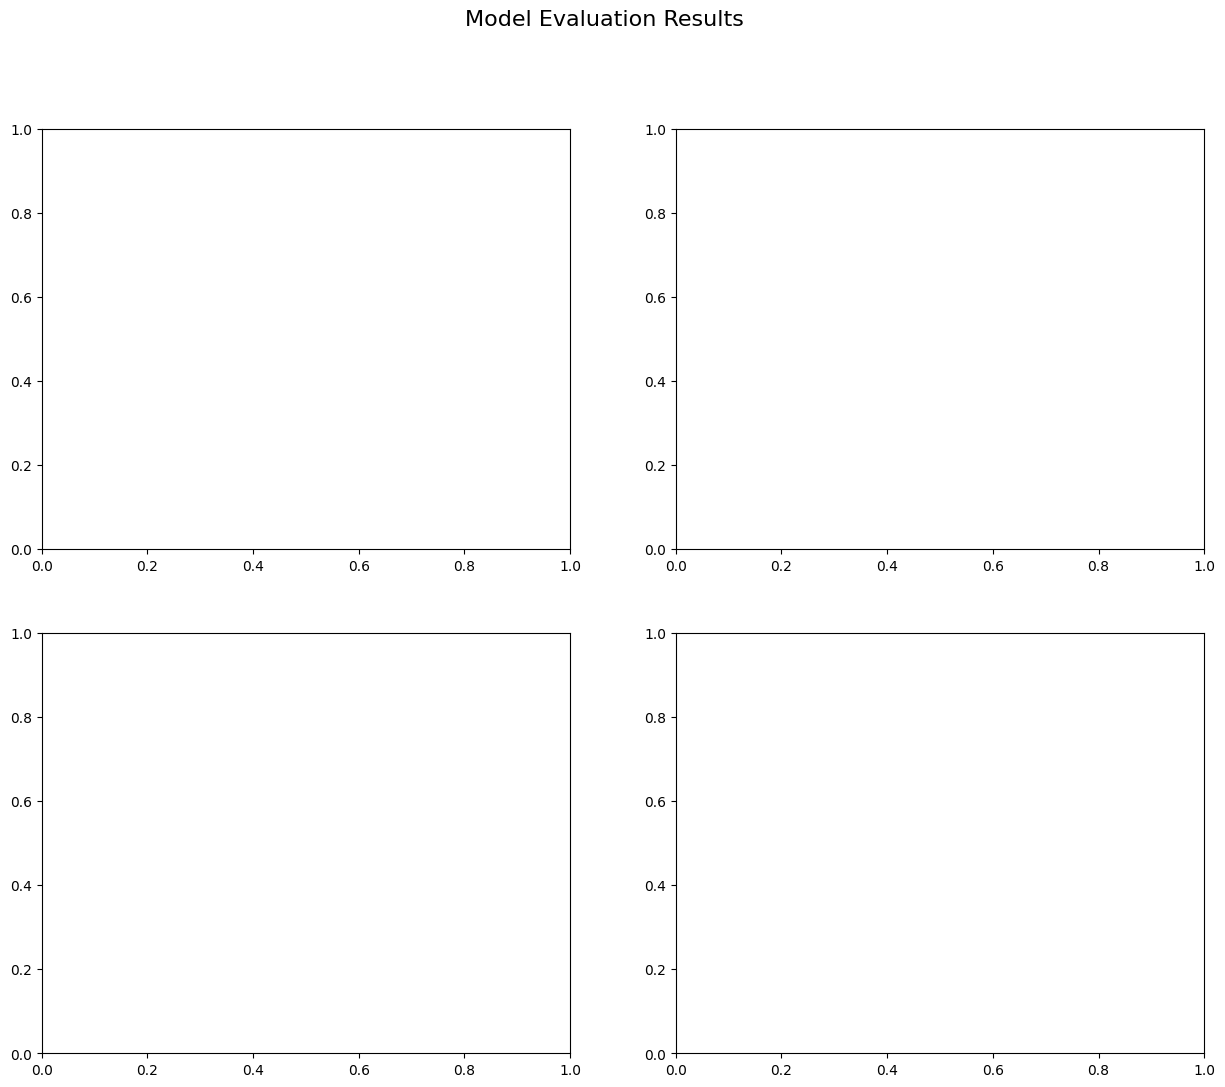

In [69]:
# Visualization of results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Evaluation Results', fontsize=16)

In [70]:
# Training history
axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()

axes[0, 1].plot(history.history['loss'], label='Training Loss')
axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 1].set_title('Model Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()

In [71]:
# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
axes[1, 0].set_title('Confusion Matrix')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')

Text(158.22222222222223, 0.5, 'Actual')

In [72]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
axes[1, 1].plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')
axes[1, 1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1, 1].set_title('ROC Curve')
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

# 6. FEATURE IMPORTANCE ANALYSIS


In [73]:
# Get feature importance from model weights
# For neural networks, we'll use the magnitude of weights from the first layer
first_layer_weights = model.layers[0].get_weights()[0]
feature_importance = np.abs(first_layer_weights).mean(axis=1)


In [74]:
# Create feature importance dataframe
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("Top 15 Most Important Features:")
print(feature_importance_df.head(15))

Top 15 Most Important Features:
                                 Feature  Importance
97    address_USNV Smith\r\nFPO AE 30723    1.149457
91   address_USS Johnson\r\nFPO AE 48052    1.110863
92  address_USNS Johnson\r\nFPO AE 05113    1.102102
94   address_USCGC Smith\r\nFPO AE 70466    1.098611
98  address_USCGC Miller\r\nFPO AA 22690    1.070900
96    address_USNV Smith\r\nFPO AA 00813    1.022387
12                            issue_year    0.884982
3                             annual_inc    0.765268
16                         grade_encoded    0.645979
93     address_USS Smith\r\nFPO AP 70466    0.605056
1                               int_rate    0.521004
15                          term_encoded    0.520014
4                                    dti    0.493297
7                              revol_bal    0.485666
5                               open_acc    0.422605


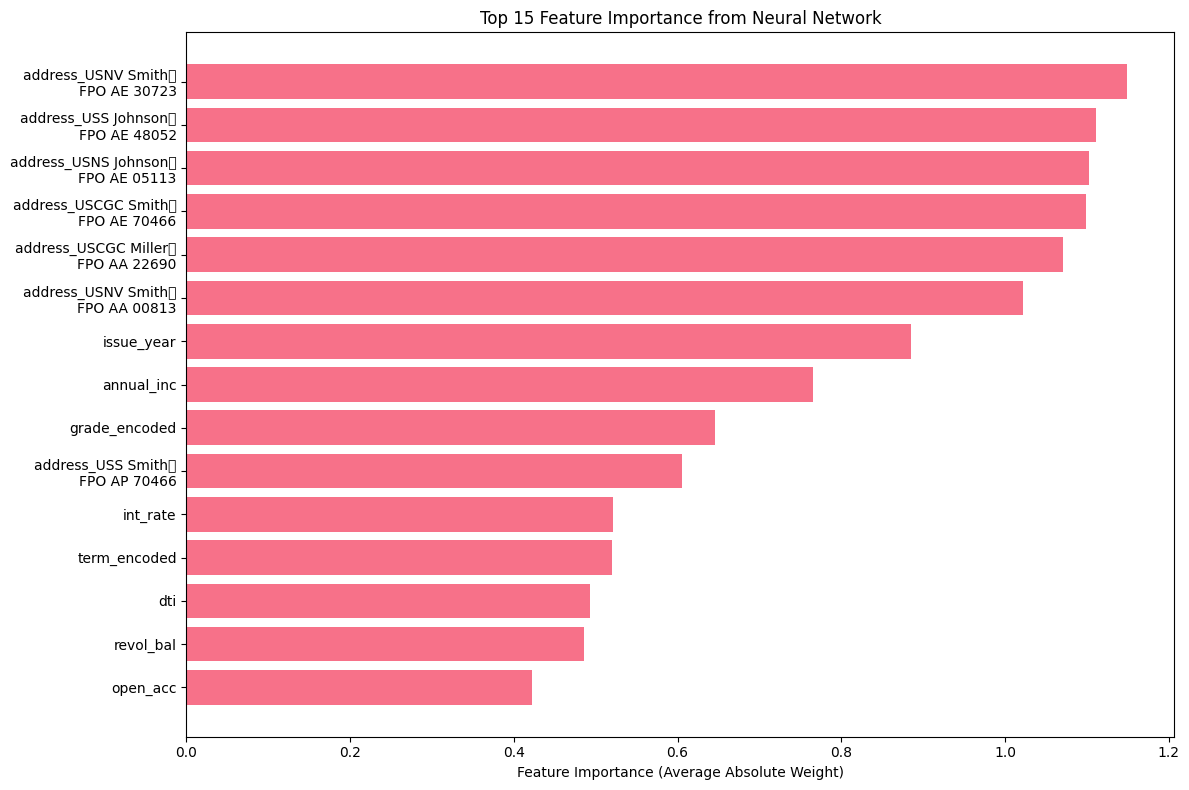

In [75]:
# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(15)
plt.barh(range(len(top_features)), top_features['Importance'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Feature Importance (Average Absolute Weight)')
plt.title('Top 15 Feature Importance from Neural Network')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 7. INTERPRETATION AND REPORTING


In [76]:
print("MODEL INTERPRETATION & INSIGHTS")
print("="*50)

print("Key Findings:")
print(f"1. Model achieved {accuracy:.1%} accuracy on the test set")
print(f"2. The model has a precision of {precision:.1%} and recall of {recall:.1%}")
print(f"3. AUC-ROC score of {auc_score:.3f} indicates {'good' if auc_score > 0.7 else 'moderate'} predictive performance")

print(f"\nTop 5 Most Important Features:")
for i, (_, row) in enumerate(feature_importance_df.head(5).iterrows(), 1):
    print(f"{i}. {row['Feature']}: {row['Importance']:.4f}")

print("\nModel Limitations and Possible Improvements:")
print("1. Class imbalance might affect model performance")
print("2. Feature engineering could be enhanced with domain knowledge")
print("3. Hyperparameter tuning could improve performance")
print("4. Ensemble methods might provide better results")
print("5. Cross-validation should be used for more robust evaluation")

print("\nRecommendations:")
print("1. Collect more balanced training data")
print("2. Implement cost-sensitive learning for imbalanced classes")
print("3. Use techniques like SMOTE for synthetic data generation")
print("4. Consider feature selection to reduce overfitting")
print("5. Implement model interpretability tools like SHAP values")

MODEL INTERPRETATION & INSIGHTS
Key Findings:
1. Model achieved 80.7% accuracy on the test set
2. The model has a precision of 81.2% and recall of 98.9%
3. AUC-ROC score of 0.725 indicates good predictive performance

Top 5 Most Important Features:
1. address_USNV Smith
FPO AE 30723: 1.1495
2. address_USS Johnson
FPO AE 48052: 1.1109
3. address_USNS Johnson
FPO AE 05113: 1.1021
4. address_USCGC Smith
FPO AE 70466: 1.0986
5. address_USCGC Miller
FPO AA 22690: 1.0709

Model Limitations and Possible Improvements:
1. Class imbalance might affect model performance
2. Feature engineering could be enhanced with domain knowledge
3. Hyperparameter tuning could improve performance
4. Ensemble methods might provide better results
5. Cross-validation should be used for more robust evaluation

Recommendations:
1. Collect more balanced training data
2. Implement cost-sensitive learning for imbalanced classes
3. Use techniques like SMOTE for synthetic data generation
4. Consider feature selection to 

In [77]:
# Save the trained model
model.save('lending_club_model.h5')
print("Model saved as 'lending_club_model.h5'")


Model saved as 'lending_club_model.h5'


In [78]:
# Save feature importance
feature_importance_df.to_csv('feature_importance.csv', index=False)
print("Feature importance saved as 'feature_importance.csv'")


Feature importance saved as 'feature_importance.csv'


In [94]:
# Save predictions
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred.flatten(),
    'Probability': y_pred_prob.flatten()
})
results_df.to_csv('model_predictions.csv', index=False)
print("Predictions saved as 'model_predictions.csv'")


Predictions saved as 'model_predictions.csv'


# 8. DETAILED METRIC SCORE SUMMARY


In [93]:
# Create a comprehensive model report
print("\n" + "="*60)
print("COMPREHENSIVE MODEL REPORT")
print("="*60)

print(f"""
MODEL PERFORMANCE SUMMARY
{'='*40}
Dataset Size: {len(X)} samples
Training Set: {len(X_train)} samples
Test Set: {len(X_test)} samples
Features Used: {len(feature_cols)}

CORE METRICS
{'='*40}
✓ Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%) - {interpretations['Accuracy']}
✓ Precision: {precision:.4f} ({precision*100:.2f}%) - {interpretations['Precision']}
✓ Recall:    {recall:.4f} ({recall*100:.2f}%) - {interpretations['Recall']}
✓ F1-Score:  {f1:.4f} ({f1*100:.2f}%) - {interpretations['F1-Score']}
✓ AUC-ROC:   {auc_score:.4f} ({auc_score*100:.2f}%) - {interpretations['AUC-ROC']}

CONFUSION MATRIX BREAKDOWN
{'='*40}
True Positives (TP):  {cm[1,1]}
True Negatives (TN):  {cm[0,0]}
False Positives (FP): {cm[0,1]}
False Negatives (FN): {cm[1,0]}

BUSINESS INSIGHTS
{'='*40}
• Model correctly identifies {accuracy*100:.1f}% of all loan outcomes
• Of predicted 'good' loans, {precision*100:.1f}% are actually good
• Model catches {recall*100:.1f}% of all actual 'good' loans
• Balanced performance score (F1): {f1*100:.1f}%
• Discrimination ability (AUC-ROC): {auc_score*100:.1f}%
""")


COMPREHENSIVE MODEL REPORT

MODEL PERFORMANCE SUMMARY
Dataset Size: 396030 samples
Training Set: 316824 samples
Test Set: 79206 samples
Features Used: 101

CORE METRICS
✓ Accuracy:  0.8066 (80.66%) - Good
✓ Precision: 0.8117 (81.17%) - Good
✓ Recall:    0.9887 (98.87%) - Excellent
✓ F1-Score:  0.8915 (89.15%) - Good
✓ AUC-ROC:   0.7250 (72.50%) - Fair

CONFUSION MATRIX BREAKDOWN
True Positives (TP):  62953
True Negatives (TN):  934
False Positives (FP): 14601
False Negatives (FN): 718

BUSINESS INSIGHTS
• Model correctly identifies 80.7% of all loan outcomes
• Of predicted 'good' loans, 81.2% are actually good
• Model catches 98.9% of all actual 'good' loans
• Balanced performance score (F1): 89.2%
• Discrimination ability (AUC-ROC): 72.5%



In [95]:
print("\n" + "="*50)
print("ANALYSIS COMPLETE!")
print("="*50)
print("The complete loan status prediction analysis has been finished.")
print("Review the visualizations and metrics above to understand model performance.")


ANALYSIS COMPLETE!
The complete loan status prediction analysis has been finished.
Review the visualizations and metrics above to understand model performance.
